# Clustering The World on COVID-19 Cases

This project attempts to cluster the world according to the pattern of COVID-19 cases in the past 28 days.

*Note - The graphs and results can be different each day, because the data is updated every day.*

Example - Clusters produced on 21st November 2020
![Clusters produced on 21st November 2020](countries-20201121.png)

## 1. Data Preparation

### Import Libraries

In [2]:
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.io as pio

from datetime import date, datetime, timedelta

from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

import joblib

width = 1000
pio.renderers.default = "plotly_mimetype+notebook_connected"

Set number of days for the study.

In [3]:
ndays = 28
dateformat = '%Y-%m-%d'

### Load Data

In [4]:
dataset_url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
df = pd.read_csv(dataset_url)
df

,Date,Country,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-23,Afghanistan,0,0,0
2,2020-01-24,Afghanistan,0,0,0
3,2020-01-25,Afghanistan,0,0,0
4,2020-01-26,Afghanistan,0,0,0
...,...,...,...,...,...
58250,2020-11-17,Zimbabwe,8945,8164,260
58251,2020-11-18,Zimbabwe,8981,8184,261
58252,2020-11-19,Zimbabwe,9046,8195,265
58253,2020-11-20,Zimbabwe,9120,8229,265


### Data Wrangling

In [5]:
df = df.assign(Cases = df['Confirmed'].diff())
df.dropna(inplace = True)
df

,Date,Country,Confirmed,Recovered,Deaths,Cases
1,2020-01-23,Afghanistan,0,0,0,0.0
2,2020-01-24,Afghanistan,0,0,0,0.0
3,2020-01-25,Afghanistan,0,0,0,0.0
4,2020-01-26,Afghanistan,0,0,0,0.0
5,2020-01-27,Afghanistan,0,0,0,0.0
...,...,...,...,...,...,...
58250,2020-11-17,Zimbabwe,8945,8164,260,48.0
58251,2020-11-18,Zimbabwe,8981,8184,261,36.0
58252,2020-11-19,Zimbabwe,9046,8195,265,65.0
58253,2020-11-20,Zimbabwe,9120,8229,265,74.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58254 entries, 1 to 58254
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       58254 non-null  object 
 1   Country    58254 non-null  object 
 2   Confirmed  58254 non-null  int64  
 3   Recovered  58254 non-null  int64  
 4   Deaths     58254 non-null  int64  
 5   Cases      58254 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.1+ MB


In [7]:
df['Cases'] = df['Cases'].astype(int)
df

,Date,Country,Confirmed,Recovered,Deaths,Cases
1,2020-01-23,Afghanistan,0,0,0,0
2,2020-01-24,Afghanistan,0,0,0,0
3,2020-01-25,Afghanistan,0,0,0,0
4,2020-01-26,Afghanistan,0,0,0,0
5,2020-01-27,Afghanistan,0,0,0,0
...,...,...,...,...,...,...
58250,2020-11-17,Zimbabwe,8945,8164,260,48
58251,2020-11-18,Zimbabwe,8981,8184,261,36
58252,2020-11-19,Zimbabwe,9046,8195,265,65
58253,2020-11-20,Zimbabwe,9120,8229,265,74


### Calculate Dates

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format = dateformat)
df.dtypes

Date         datetime64[ns]
Country              object
Confirmed             int64
Recovered             int64
Deaths                int64
Cases                 int32
dtype: object

In [9]:
df.drop(['Confirmed', 'Recovered', 'Deaths'], axis = 1, inplace = True)
df

,Date,Country,Cases
1,2020-01-23,Afghanistan,0
2,2020-01-24,Afghanistan,0
3,2020-01-25,Afghanistan,0
4,2020-01-26,Afghanistan,0
5,2020-01-27,Afghanistan,0
...,...,...,...
58250,2020-11-17,Zimbabwe,48
58251,2020-11-18,Zimbabwe,36
58252,2020-11-19,Zimbabwe,65
58253,2020-11-20,Zimbabwe,74


In [10]:
end = df['Date'].max()
end

Timestamp('2020-11-21 00:00:00')

In [11]:
start = end - timedelta(days = (ndays - 1))
start

Timestamp('2020-10-25 00:00:00')

### Create New Table

In [12]:
df_period = df[df['Date'] >= start]
df_period

,Date,Country,Cases
277,2020-10-25,Afghanistan,65
278,2020-10-26,Afghanistan,104
279,2020-10-27,Afghanistan,95
280,2020-10-28,Afghanistan,113
281,2020-10-29,Afghanistan,123
...,...,...,...
58250,2020-11-17,Zimbabwe,48
58251,2020-11-18,Zimbabwe,36
58252,2020-11-19,Zimbabwe,65
58253,2020-11-20,Zimbabwe,74


In [13]:
countries = df_period['Country'].unique()
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [14]:
df_grouped = df_period.groupby('Country')
df_grouped

In [15]:
sums = df_grouped['Cases'].sum()
sums

Country
Afghanistan            3735
Albania               13338
Algeria               17894
Andorra                2169
Angola                 5387
                      ...  
West Bank and Gaza    20265
Western Sahara            0
Yemen                    33
Zambia                 1277
Zimbabwe                903
Name: Cases, Length: 191, dtype: int32

In [16]:
means = df_grouped['Cases'].mean()
means

Country
Afghanistan           133.392857
Albania               476.357143
Algeria               639.071429
Andorra                77.464286
Angola                192.392857
                         ...    
West Bank and Gaza    723.750000
Western Sahara          0.000000
Yemen                   1.178571
Zambia                 45.607143
Zimbabwe               32.250000
Name: Cases, Length: 191, dtype: float64

In [17]:
stds = df_grouped['Cases'].std()
stds

Country
Afghanistan            74.563589
Albania               168.057577
Algeria               286.203363
Andorra                59.420960
Angola                 74.792721
                         ...    
West Bank and Gaza    294.968501
Western Sahara          0.000000
Yemen                   1.656716
Zambia                 27.793337
Zimbabwe               20.879948
Name: Cases, Length: 191, dtype: float64

In [18]:
maxes = df_grouped['Cases'].max()
maxes

Country
Afghanistan            377
Albania                836
Algeria               1103
Andorra                287
Angola                 355
                      ... 
West Bank and Gaza    1486
Western Sahara           0
Yemen                    6
Zambia                 118
Zimbabwe                74
Name: Cases, Length: 191, dtype: int32

In [19]:
mins = df_grouped['Cases'].min()
mins

Country
Afghanistan            40
Albania               241
Algeria               263
Andorra                 0
Angola                 77
                     ... 
West Bank and Gaza    420
Western Sahara          0
Yemen                   0
Zambia                  0
Zimbabwe                5
Name: Cases, Length: 191, dtype: int32

In [20]:
medians = df_grouped['Cases'].median()
medians

Country
Afghanistan           117.0
Albania               489.5
Algeria               642.0
Andorra                66.0
Angola                194.0
                      ...  
West Bank and Gaza    638.0
Western Sahara          0.0
Yemen                   0.0
Zambia                 41.0
Zimbabwe               28.0
Name: Cases, Length: 191, dtype: float64

In [21]:
df_countries = pd.DataFrame(
    {
        'Country': countries,
        'Sum': sums,
        'Mean': means,
        'Std': stds,
        'Max': maxes,
        'Min': mins,
        'Median': medians
    }
)

df_countries

,Country,Sum,Mean,Std,Max,Min,Median
Country,,,,,,,
Afghanistan,Afghanistan,3735,133.392857,74.563589,377,40,117.0
Albania,Albania,13338,476.357143,168.057577,836,241,489.5
Algeria,Algeria,17894,639.071429,286.203363,1103,263,642.0
Andorra,Andorra,2169,77.464286,59.420960,287,0,66.0
Angola,Angola,5387,192.392857,74.792721,355,77,194.0
...,...,...,...,...,...,...,...
West Bank and Gaza,West Bank and Gaza,20265,723.750000,294.968501,1486,420,638.0
Western Sahara,Western Sahara,0,0.000000,0.000000,0,0,0.0
Yemen,Yemen,33,1.178571,1.656716,6,0,0.0


In [22]:
df_countries.reset_index(drop = True, inplace = True)
df_countries

,Country,Sum,Mean,Std,Max,Min,Median
0,Afghanistan,3735,133.392857,74.563589,377,40,117.0
1,Albania,13338,476.357143,168.057577,836,241,489.5
2,Algeria,17894,639.071429,286.203363,1103,263,642.0
3,Andorra,2169,77.464286,59.420960,287,0,66.0
4,Angola,5387,192.392857,74.792721,355,77,194.0
...,...,...,...,...,...,...,...
186,West Bank and Gaza,20265,723.750000,294.968501,1486,420,638.0
187,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,Yemen,33,1.178571,1.656716,6,0,0.0
189,Zambia,1277,45.607143,27.793337,118,0,41.0


### Explore Data

In [23]:
df_countries.isnull().sum()

Country    0
Sum        0
Mean       0
Std        0
Max        0
Min        0
Median     0
dtype: int64

In [24]:
df_countries[df_countries['Country'] == 'US']

,Country,Sum,Mean,Std,Max,Min,Median
176,US,3523818,125850.642857,39828.079914,195542,61760,125437.5


In [25]:
df_countries[df_countries['Country'] == 'India']

,Country,Sum,Mean,Std,Max,Min,Median
79,India,1230995,43964.107143,5379.711725,50356,29163,45403.5


In [26]:
df_countries[df_countries['Country'] == 'Malaysia']

,Country,Sum,Mean,Std,Max,Min,Median
107,Malaysia,27937,997.75,239.737144,1755,649,965.0


## 2. Data Visualization

In [27]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Sum')
fig.update_layout(title_text = f'COVID-19 - Total Number of Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [28]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Mean')
fig.update_layout(title_text = f'COVID-19 - Daily Average Number of Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [29]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Std', width = width)
fig.update_layout(title_text = f'COVID-19 - Standard Deviation of Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [30]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Max')
fig.update_layout(title_text = f'COVID-19 - Highest Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [31]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Min')
fig.update_layout(title_text = f'COVID-19 - Lowest Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [32]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Median')
fig.update_layout(title_text = f'COVID-19 - Median Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [33]:
df_countries.corr()

,Sum,Mean,Std,Max,Min,Median
Sum,1.000000,1.000000,0.897142,0.955540,0.926661,0.999314
Mean,1.000000,1.000000,0.897142,0.955540,0.926661,0.999314
Std,0.897142,0.897142,1.000000,0.982278,0.678346,0.884866
Max,0.955540,0.955540,0.982278,1.000000,0.788188,0.946420
Min,0.926661,0.926661,0.678346,0.788188,1.000000,0.934631
Median,0.999314,0.999314,0.884866,0.946420,0.934631,1.000000


## Model Training

In [34]:
# Features = df_countries.drop(['Country', 'Sum'], axis = 1).columns # Use almost all columns for training
Features = ['Median', 'Std'] # Use selected columns for training
Features

['Median', 'Std']

In [35]:
scaled_features = StandardScaler().fit_transform(df_countries[Features])

In [36]:
start = 2
end = 11

sse = []

kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

for k in range(start, end):
    print(f'Trying {k} clusters...')
    
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    print(f'SSE: {kmeans.inertia_}')
    
    print()

Trying 2 clusters...
SSE: 158.17014209742996

Trying 3 clusters...
SSE: 71.62210813954903

Trying 4 clusters...
SSE: 38.1277736818024

Trying 5 clusters...
SSE: 21.572430863293192

Trying 6 clusters...
SSE: 17.463722245281485

Trying 7 clusters...
SSE: 16.763238673957005

Trying 8 clusters...
SSE: 15.542454582824886

Trying 9 clusters...
SSE: 15.310825923550324

Trying 10 clusters...
SSE: 15.269303570959366



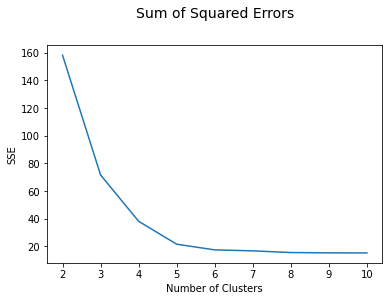

In [37]:
plt.plot(range(start, end), sse)
plt.xticks(range(start, end))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors', y = 1.1, fontsize = 14)
plt.show()

In [38]:
kl = KneeLocator(
   range(start, end), sse, curve="convex", direction="decreasing"
)

print(f'The optimal number of clusters: {kl.elbow}')

The optimal number of clusters: 4


In [39]:
kclusters = kl.elbow

kmeans = KMeans(n_clusters = kclusters, **kmeans_kwargs)
kmeans.fit(scaled_features)

labels = kmeans.labels_ + 1
labels

array([1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Explore Clusters

In [40]:
if 'Cluster' in df_countries.columns:
    df_countries.drop('Cluster', axis = 1, inplace = True)
    
df_countries.insert(0, 'Cluster', labels)
df_countries

,Cluster,Country,Sum,Mean,Std,Max,Min,Median
0,1,Afghanistan,3735,133.392857,74.563589,377,40,117.0
1,1,Albania,13338,476.357143,168.057577,836,241,489.5
2,1,Algeria,17894,639.071429,286.203363,1103,263,642.0
3,1,Andorra,2169,77.464286,59.420960,287,0,66.0
4,1,Angola,5387,192.392857,74.792721,355,77,194.0
...,...,...,...,...,...,...,...,...
186,1,West Bank and Gaza,20265,723.750000,294.968501,1486,420,638.0
187,1,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,1,Yemen,33,1.178571,1.656716,6,0,0.0
189,1,Zambia,1277,45.607143,27.793337,118,0,41.0


In [41]:
df_countries

,Cluster,Country,Sum,Mean,Std,Max,Min,Median
0,1,Afghanistan,3735,133.392857,74.563589,377,40,117.0
1,1,Albania,13338,476.357143,168.057577,836,241,489.5
2,1,Algeria,17894,639.071429,286.203363,1103,263,642.0
3,1,Andorra,2169,77.464286,59.420960,287,0,66.0
4,1,Angola,5387,192.392857,74.792721,355,77,194.0
...,...,...,...,...,...,...,...,...
186,1,West Bank and Gaza,20265,723.750000,294.968501,1486,420,638.0
187,1,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,1,Yemen,33,1.178571,1.656716,6,0,0.0
189,1,Zambia,1277,45.607143,27.793337,118,0,41.0


### Visualize Clusters

In [42]:
df_plot = pd.DataFrame(df_countries['Cluster'].value_counts(sort = False))
df_plot.index.name = 'Cluster'
df_plot.columns = ['Count']
df_plot

,Count
Cluster,
1,170
2,5
3,15
4,1


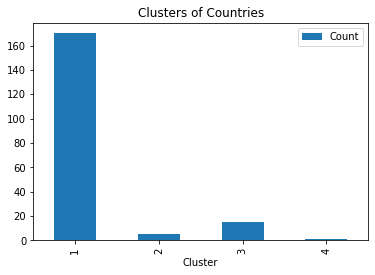

In [43]:
df_plot.plot.bar(title = 'Clusters of Countries')

Learn the characteristics of each cluster.

In [44]:
df_clusters = df_countries.groupby('Cluster')
df_clusters

In [45]:
df_clusters['Sum'].mean()

Cluster
1    1.713406e+04
2    8.766210e+05
3    3.151671e+05
4    3.523818e+06
Name: Sum, dtype: float64

In [46]:
df_clusters['Mean'].mean()

Cluster
1       611.930672
2     31307.892857
3     11255.966667
4    125850.642857
Name: Mean, dtype: float64

In [47]:
df_clusters['Std'].mean()

Cluster
1      216.806392
2    13795.576744
3     3488.813895
4    39828.079914
Name: Std, dtype: float64

In [48]:
df_clusters['Max'].mean()

Cluster
1      1082.594118
2     64069.200000
3     18638.266667
4    195542.000000
Name: Max, dtype: float64

In [49]:
df_clusters['Min'].mean()

Cluster
1      241.670588
2     9245.400000
3     5592.466667
4    61760.000000
Name: Min, dtype: float64

In [50]:
df_clusters['Median'].mean()

Cluster
1       610.258824
2     31060.100000
3     10952.000000
4    125437.500000
Name: Median, dtype: float64

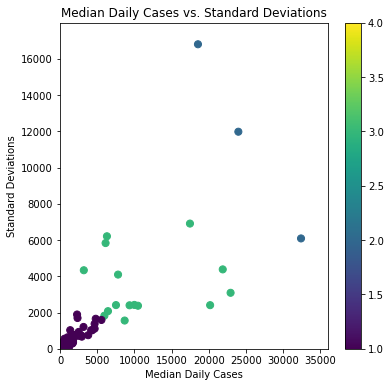

In [51]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)

scatter = ax.scatter(df_countries['Median'], df_countries['Std'], c = df_countries['Cluster'], s = 50)

ax.set_title('Median Daily Cases vs. Standard Deviations')
ax.set_xlabel('Median Daily Cases')
ax.set_ylabel('Standard Deviations')
ax.set_xlim(0, df_countries['Median'].quantile(0.99))
ax.set_ylim(0, df_countries['Std'].quantile(0.99))

plt.colorbar(scatter)

### List Clusters

In [52]:
for i in range(1, kclusters + 1):
    print(df_clusters.get_group(i))

     Cluster             Country    Sum        Mean         Std   Max  Min  \
0          1         Afghanistan   3735  133.392857   74.563589   377   40   
1          1             Albania  13338  476.357143  168.057577   836  241   
2          1             Algeria  17894  639.071429  286.203363  1103  263   
3          1             Andorra   2169   77.464286   59.420960   287    0   
4          1              Angola   5387  192.392857   74.792721   355   77   
..       ...                 ...    ...         ...         ...   ...  ...   
186        1  West Bank and Gaza  20265  723.750000  294.968501  1486  420   
187        1      Western Sahara      0    0.000000    0.000000     0    0   
188        1               Yemen     33    1.178571    1.656716     6    0   
189        1              Zambia   1277   45.607143   27.793337   118    0   
190        1            Zimbabwe    903   32.250000   20.879948    74    5   

     Median  
0     117.0  
1     489.5  
2     642.0  
3      

In [53]:
category_order = {'Cluster': list(range(1, kclusters + 1))}
category_order

{'Cluster': [1, 2, 3, 4]}

In [54]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = df_countries['Cluster'])
fig.update_layout(title_text = f'Clustering The World into {kclusters} Clusters based on COVID-19 Cases in Past {ndays} Days', title_x = 0.5)
fig.update_coloraxes(showscale = False)
fig.show()

### Save Data

In [55]:
timestamp = datetime.now().strftime('%Y%m%d%H%M')

In [56]:
df_countries.to_csv('countries-' + timestamp + '.csv', index = False)

In [59]:
joblib.dump(kmeans, 'model-' + timestamp + '.pkl')

['model-202011221828.pkl']